# Shadow removal with luminance clustering and color clustering
From previous try, it is clear that the penumbra must be considered, i.e., instead of just limiarizing the scene into lit and shadow regions, it probably would have better result by dividing the scenario into lit, penumbra and umbra regions.

In [1]:
import numpy as np
import imageio
import matplotlib as mpl
import matplotlib.pyplot as plt

## Enhancing image with adaptive denoising
Firstly, since in this work the specific scenarios of eucalyptus forests are really noisy, an adaptive denoise filter was implemented, so the noisy regions became smoother without loosing the borders.

In [2]:
# Adaptive Denoising
def adaptive_denoising(g, k, gamma, denoise_mode):
    # calculate the center of kernel
    a = k//2

    # create a zero matrix to fill with denoising result
    r = np.zeros(g.shape)

    # declaration of image dispersion measure, local dispersion measure and centrality measure
    gdisp = 0.0
    ldisp = 0.0
    centr = 0.0

    # compute the estimation of the image global dispersion in a determined subregion of the image accordig to the assignment description
    subregion = g[0:(g.shape[0]//6), 0:(g.shape[1]//6)]
    if(denoise_mode == "average"):
        gdisp = np.std(subregion)
    if(denoise_mode == "robust"):
        q1, c, q2 = np.percentile(subregion, [25, 50, 75])
        gdisp = q2 - q1

    # "If the dispersion measure computed for some image is 0, then manually set it to 1"
    if(gdisp == 0):
        gdisp = 1

    # loop to run all over the image and denoise it
    for x in range(g.shape[0]):
        for y in range(g.shape[1]):
            # if running at the border of the image, when the filter kernel exceeds the limits of the image
            # then the resulting value is the copy of original image's pixel.
            if(x<a or x>(g.shape[0]-a) or y<a or y>(g.shape[1]-a)):
                r[x,y] = g[x,y]

            # else compute the filter
            else:
                # Sx is the image region, kernel size, to be filtered
                Sx = g[x-a:(x+a+1), y-a:(y+a+1)]
                
                # compute the local dispersion and centrality measure, according to denoise mode (average/robust)
                if(denoise_mode == "average"):
                    # if denoise mode is average, dispersion is standard deviation and the centrality is the mean of region Sx
                    ldisp = np.std(Sx)
                    centr = np.mean(Sx)
                elif(denoise_mode == "robust"):
                    # if denoise mode is robust, dispersion is interquartile range and the centrality is the median of region Sx
                    q1, centr, q2 = np.percentile(Sx, [25, 50, 75])
                    ldisp = q2 - q1
                
                # "If during the denoising step, any local dispersion measure is 0, then set it so that local dispersion = global dispersion"
                if(ldisp == 0):
                    ldisp = gdisp
                
                # formula of adaptive denoising
                r[x,y] = int(g[x,y] - gamma*(gdisp/ldisp)*(g[x,y]-centr))
    
    return r

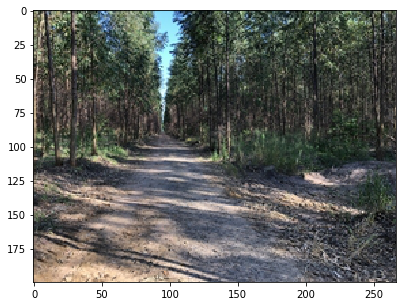

In [3]:
img = imageio.imread("../images/shadow5.jpg")
for i in range(3):
    img[:,:,i] = adaptive_denoising(img[:,:,i],3,0.005,"average")

plt.figure(figsize=(10,5))
plt.imshow(img)

## Luminance clustering
Given the scene, the first step is to detect the shadow (penumbra and umbra) regions of it by clustering the image using as attribute the luminance, which is calculated with the form:

*luminance = 0.299 * R + 0.587 * G + 0.114 * B*

In [4]:
# find the closest cluster to the example pixel
def closest_cluster(centroids, example):
    # calculate the euclidian distances of the example from all centroids
    distances = np.linalg.norm(np.subtract(centroids, example),axis=1)

    # return the cluster number in which there is the min distance value
    return (np.where(distances == np.min(distances))[0][0] + 1)

In [5]:
# after each iteration, the centroids coordinates are updated
def update_centroids(labeled_dataset, dataset, centroids):
    # for each centroid, compute the average values of all respective pixels attributes
    for c in range(centroids.shape[0]):
        # get all pixels that belongs to 'c' cluster
        cluster = dataset[np.where(labeled_dataset == c+1)]

        # compute the average of attributes values
        if(cluster.shape[0] != 0):
            centroids[c] = np.mean(cluster,axis=0)

    return centroids

In [6]:
# function to run the k-means routine in 'n' iterations
def kmeans_routine(dataset, centroids, k, n):
    r=centroids.shape[1]
    # create the frame for labeling the image
    label_img = np.zeros((dataset.shape[0],dataset.shape[1]), dtype=np.uint8)

    # loop to repeat 'n' times the iteration
    for iteration in range(n):
        # loops to run all dataset, labeling the objects according to centroids similarity
        for x in range(dataset.shape[0]):
            for y in range(dataset.shape[1]):
                if(np.sum(dataset[x,y]) == 0):
                    label_img[x,y] = 1
                else:
                    # collect an example object from dataset to be labeled
                    example = dataset[x,y]

                    # according to similarity, select the cluster in which the example belongs
                    cluster = closest_cluster(centroids, example)
                    # set the label_img pixel value to cluster's number
                    label_img[x,y] = cluster

        # update the centroids by calculating the average of attributes of each formed clusters
        centroids = update_centroids(label_img, dataset, centroids)
        
    return label_img

In [7]:
luminance_dataset = 0.299*img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2]

luminance_centroids = np.array([[np.min(luminance_dataset)], 
                                [np.max(luminance_dataset)/2], 
                                [np.max(luminance_dataset)]])

lus = kmeans_routine(luminance_dataset, luminance_centroids, luminance_centroids.shape[0], 5)

The resulting clusters with lit, penumbra and umbra regions can be seen below, in which lit regions pixel are labeled as 3, penumbra regions pixels as 2, and umbra regions pixels as 1.

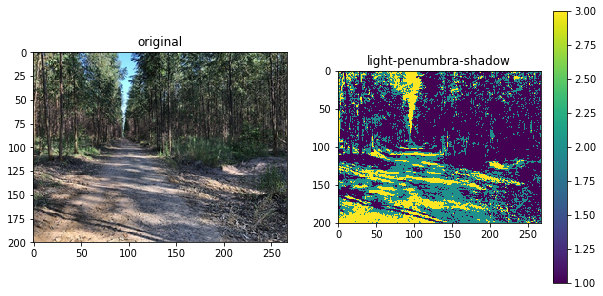

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(121); plt.imshow(img); plt.title("original")
plt.subplot(122); plt.imshow(lus); plt.title("light-penumbra-shadow"); plt.colorbar()

From this clusters, three binary masks were extracted of each of these regions (lig, penumbra and umbra).

Text(0.5, 1.0, 'umbra mask')

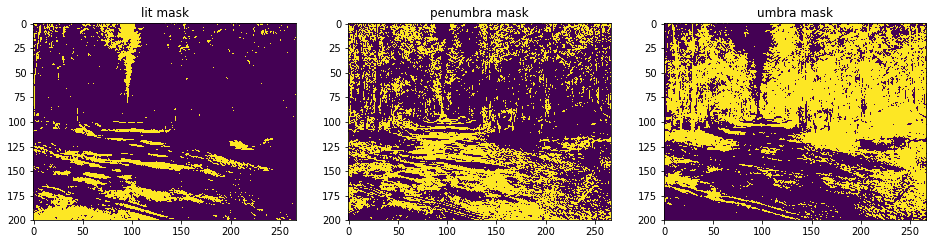

In [9]:
lit_mask = np.zeros((img.shape[0], img.shape[1]))
penumbra_mask = np.zeros((img.shape[0], img.shape[1]))
umbra_mask = np.zeros((img.shape[0], img.shape[1]))

lit_mask[np.where(lus==3)] = 1
penumbra_mask[np.where(lus==2)] = 1
umbra_mask[np.where(lus==1)] = 1

lit_img = np.zeros(img.shape, dtype=np.uint8)
penumbra_img = np.zeros(img.shape, dtype=np.uint8)
umbra_img = np.zeros(img.shape, dtype=np.uint8)
for i in range(3):
    lit_img[:,:,i] = np.multiply(lit_mask,img[:,:,i])
    penumbra_img[:,:,i] = np.multiply(penumbra_mask,img[:,:,i])
    umbra_img[:,:,i] = np.multiply(umbra_mask,img[:,:,i])

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.imshow(lit_mask)
plt.title("lit mask")
plt.subplot(132)
plt.imshow(penumbra_mask)
plt.title("penumbra mask")
plt.subplot(133)
plt.imshow(umbra_mask)
plt.title("umbra mask")

In [10]:
def label_frame(frame, dataset, clusters):
    for i in range(1,np.max(clusters)+1):
        cluster = dataset[np.where(clusters == i)]
        coordinates = (cluster[:,-2],cluster[:,-1])
        frame[coordinates] = i
    
    return(frame)

## Color clustering of each luminance cluster
The idea is to equalize de color distribution on shadow regions (both penumbra and umbra), according to each color cluster from lit regions.
In other words, from lit road histogram equalize the histogram in road penumbra and road umbra, and analogously for forests on both side of road.

For that, this step aims clustering the lit, penumbra and umbra reigons into 4 subgroups: sky, road, forest in left side of road and forest in right side of forest, based on the color channels (R,G,B) and the pixel position (x,y).

In [11]:
""" color clustering on lit regions """
lit_clusters_mask = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)

idx, idy = np.where(lus == luminance_centroids.shape[0])
coordinates = np.append(np.transpose([idx]),np.transpose([idy]),axis=1)
lit_dataset = np.dstack(([img[np.where(lus == luminance_centroids.shape[0])]],
                           [coordinates]))


lit_centroids=np.array([[np.max(lit_dataset[:,:,0]),0,0,img.shape[0]-1,img.shape[1]//2],
                         [0,np.max(lit_dataset[:,:,1]),0,img.shape[0]//2,0],
                         [0,np.max(lit_dataset[:,:,1]),0,img.shape[0]//2,img.shape[1]-1],
                         [0,0,np.max(lit_dataset[:,:,2]),0,img.shape[1]//2]])

lit_clusters = kmeans_routine(lit_dataset, lit_centroids, 4, 2)

lit_clusters_mask = label_frame(lit_mask, lit_dataset, lit_clusters)

In [12]:
""" color clustering on umbra regions """
umbra_clusters_mask = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)

idx, idy = np.where(lus == 1)
coordinates = np.append(np.transpose([idx]),np.transpose([idy]),axis=1)
umbra_dataset = np.dstack(([img[np.where(lus == 1)]],
                           [coordinates]))

umbra_centroids=np.array([[np.max(umbra_dataset[:,:,0]),0,0,img.shape[0]-1,img.shape[1]//2],
                         [0,np.max(umbra_dataset[:,:,1]),0,img.shape[0]//2,0],
                         [0,np.max(umbra_dataset[:,:,2]),0,img.shape[0]//2,img.shape[1]-1],
                         [0,0,np.max(umbra_dataset[:,:,2]),0,img.shape[1]//2]])

umbra_clusters = kmeans_routine(umbra_dataset, umbra_centroids, 3, 2)

umbra_clusters_mask = label_frame(umbra_mask, umbra_dataset, umbra_clusters)

In [13]:
""" color clustering on penumbra regions """
penumbra_clusters_mask = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)

idx, idy = np.where(lus == 2)
coordinates = np.append(np.transpose([idx]),np.transpose([idy]),axis=1)
penumbra_dataset = np.dstack(([img[np.where(lus == 2)]],
                           [coordinates]))

penumbra_centroids=np.array([[np.max(penumbra_dataset[:,:,0]),0,0,img.shape[0]-1,img.shape[1]//2],
                         [0,np.max(penumbra_dataset[:,:,1]),0,img.shape[0]//2,0],
                         [0,np.max(penumbra_dataset[:,:,2]),0,img.shape[0]//2,img.shape[1]-1],
                         [0,0,np.max(penumbra_dataset[:,:,2]),0,img.shape[1]//2]])

penumbra_clusters = kmeans_routine(penumbra_dataset, penumbra_centroids, 3, 2)

penumbra_clusters_mask = label_frame(penumbra_mask, penumbra_dataset, penumbra_clusters)

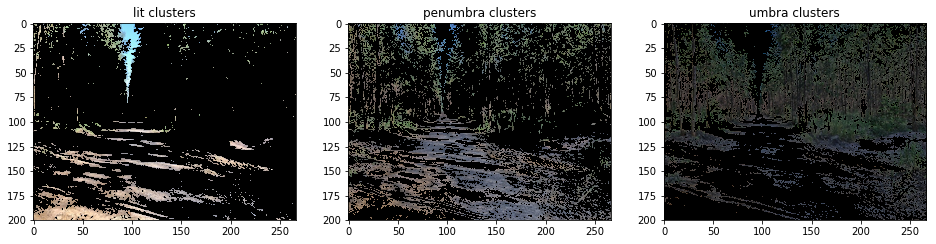

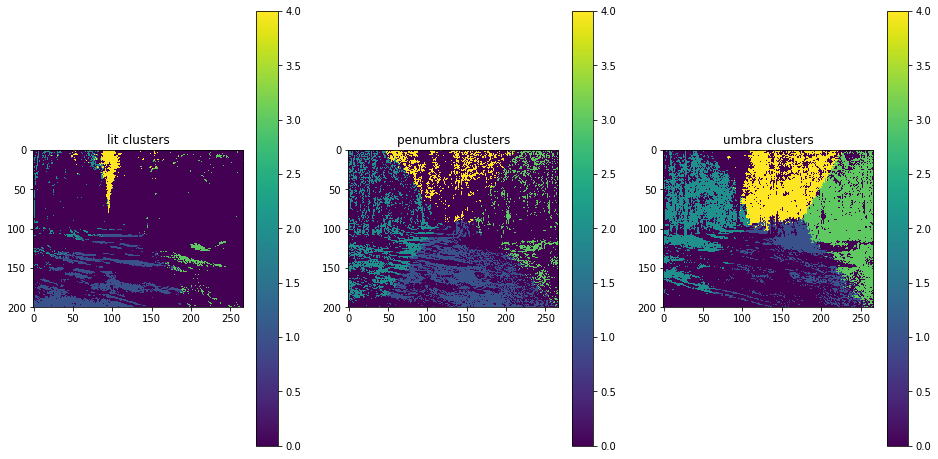

In [16]:
plt.figure(figsize=(16,8))
plt.subplot(131);plt.imshow(lit_img);plt.title("lit clusters")
plt.subplot(132);plt.imshow(penumbra_img);plt.title("penumbra clusters")
plt.subplot(133);plt.imshow(umbra_img);plt.title("umbra clusters")

plt.figure(figsize=(16,8))
plt.subplot(131);plt.imshow(lit_clusters_mask);plt.title("lit clusters");plt.colorbar()
plt.subplot(132);plt.imshow(penumbra_clusters_mask);plt.title("penumbra clusters");plt.colorbar()
plt.subplot(133);plt.imshow(umbra_clusters_mask);plt.title("umbra clusters");plt.colorbar()

## Equalizing the penumbra and umbra regions
Now that all subgroups were clusterized, it is possible to equalize their color distribution based on lit regions.

In [20]:
img_copy = np.copy(img)

""" Equalizing all clusters on penumbra group """
# loop for each cluster
for g in range(1,5):
    penumbra_coordinates = np.where(penumbra_clusters_mask==g)

    # loop for each color layer
    for c in range(3):
        litmean = np.average(img[np.where(lit_clusters_mask==g)][:,c])
        litstd = np.std(img[np.where(lit_clusters_mask==g)][:,c])
        litmin = litmean - litstd
        litmax = litmean + litstd
        
        penumbramin = np.min(img[penumbra_coordinates][:,c])
        penumbramax = np.max(img[penumbra_coordinates][:,c])
        
        for i in range(penumbra_coordinates[0].shape[0]):
            x,y,z=penumbra_coordinates[0][i],penumbra_coordinates[1][i],c
            img_copy[x,y,z]=((float(img[x,y,z])-penumbramin)*(litmax - litmin)/(penumbramax - penumbramin)) + litmin

""" Equalizing all clusters on umbra group """
# loop for each cluster
for g in range(1,5):
    umbra_coordinates = np.where(umbra_clusters_mask==g)

    # loop for each color layer
    for c in range(3):
        litmean = np.average(img[np.where(lit_clusters_mask==g)][:,c])
        litstd = np.std(img[np.where(lit_clusters_mask==g)][:,c])
        litmin = litmean - litstd
        litmax = litmean + litstd
        
        umbramin = np.min(img[umbra_coordinates][:,c])
        umbramax = np.max(img[umbra_coordinates][:,c])
        
        for i in range(umbra_coordinates[0].shape[0]):
            x,y,z=umbra_coordinates[0][i],umbra_coordinates[1][i],c
            img_copy[x,y,z]=((float(img[x,y,z])-umbramin)*(litmax - litmin)/(umbramax - umbramin)) + litmin
            

## Results and Discution
Since the subgroups of each luminance cluster were formed clearly different on space, the equalization of each of these parts had bad results, far from expected.

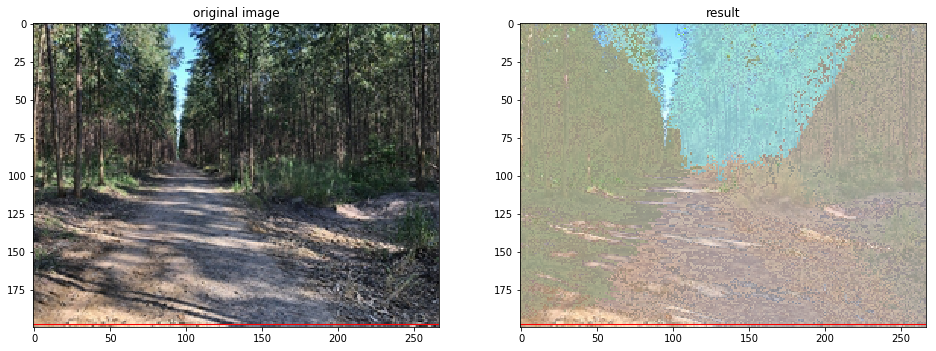

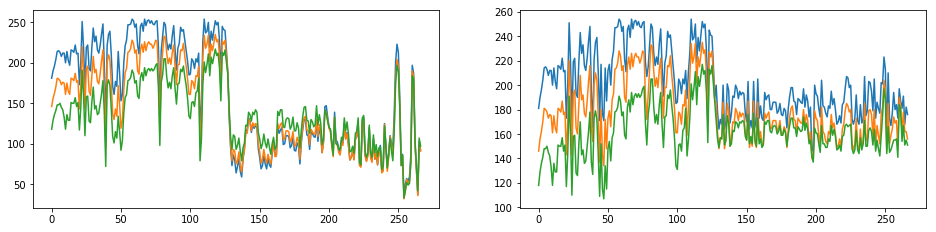

In [22]:
hline = -2
original = np.copy(img)
result = np.copy(img_copy)
original[hline,:] = [255,0,0]
result[hline,:] = [255,0,0]

plt.figure(figsize=(16,16))
plt.subplot(221);plt.imshow(original);plt.title("original image")
plt.subplot(222);plt.imshow(result);plt.title("result")
plt.figure(figsize=(16,8))
plt.subplot(223);plt.plot(img[-1,:])
plt.subplot(224);plt.plot(img_copy[-1,:])